In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
!cp gdrive/My\ Drive/optical_data.zip .
!unzip optical_data.zip

Archive:  optical_data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: data/.DS_Store          
replace __MACOSX/data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: __MACOSX/data/._.DS_Store  
replace data/Class3/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Class3/.DS_Store   
replace __MACOSX/data/Class3/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: __MACOSX/data/Class3/._.DS_Store  
replace data/Class3/Test/0298.PNG? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: data/Class3/Test/0298.PNG  
replace __MACOSX/data/Class3/Test/._0298.PNG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
!ls data

Class1	Class2	Class3	Class4	Class5	Class6	Class7


In [2]:
import os
import sys
import time
import warnings
from random import shuffle

%tensorflow_version 1.x

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
import numpy as np
import keras
from keras import backend as K
import cv2

warnings.filterwarnings("ignore")

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Not all data in the dataset has defects. We only use the images which have defects
# This function takes the dataset_type as a parameter. You can pass "Train" or "Test"
# as argument to get the appropriate dataset
def load_data(dataset_type="Train"):
    file_list = {}
    defect_map = {}
    file_name = []
    file_mask = []
    count = 0
    num_classes = 6

    data_dir = "data"
    for x in range(1, num_classes + 1):
        path = os.path.join(os.path.join(data_dir, "Class" + str(x)), dataset_type)
        df = pd.read_fwf(path + "/Label/Labels.txt")
        count = 0
        for i in range(0, len(df)):
            curr_file = path + "/" + str(df.iloc[i][2])
            if (df.iloc[i][1] == 1):
                file_list[curr_file] = path + "/Label/" + str(df.iloc[i][4])
                defect_map[curr_file] = 1
            else:
                fnametest = str(df.iloc[i][2]).split(".")
                file_list[curr_file] = str(path + "/Label/" + fnametest[0] + "_label.PNG")
                defect_map[curr_file] = 0

    items = list(file_list.keys())
    shuffle(items)
    for key in items:
        if ((not os.path.exists(key)) or (not os.path.exists(file_list[key]))):
            # print ("Missing mask for ", key)
            continue

        if defect_map[key] == 1:
            file_name.append(key)
            file_mask.append(file_list[key])
        elif count < 80 * num_classes:
            file_name.append(key)
            file_mask.append(file_list[key])
            count = count + 1

    return file_name, file_mask

In [0]:
# This is generator class to process data in batches and send them for training
class Surface_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, test=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    # return the total number of batches you have i.e., total_files/batch_size
    def __len__(self):
        # YOUR CODE HERE
        # return ...
        return int(np.floor(len(self.image_filenames) / self.batch_size)) + 1

    # this function is called for every mini-batch to get the images/masks for that mini-batch
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_arr = []
        mask_arr = []
        # Open a batch of images and their corresponding masks using cv2.imread
        # resize them to 512x512x1 and return an np.array of images and masks
        # YOUR CODE HERE
        for x in batch_x:
          image_arr.append(resize(cv2.imread(x,0),(512,512,1)))
        for y in batch_y:
          mask_arr.append(resize(cv2.imread(y,0),(512,512,1)))

        return np.array(image_arr).astype(np.float32), np.array(mask_arr).astype(np.float32)
    
    # for testing we need to get the list of all true masks
    # this function should return all the labels in the dataset set 
    # we will call this function only for the "Test" dataset
    def get_all_masks(self):
        mask_arr = []
        
        # YOUR CODE HERE
        for x in self.labels:
          mask_arr.append(resize(cv2.imread(x,0),(512,512,1)))

        return np.array(mask_arr).astype(np.float32)


In [0]:
# Since we already have a split for training and test set,
# we just need to split training set to get a validation set

# Load training data
X, Y = load_data("Train")

In [0]:
from sklearn.model_selection import train_test_split

In [24]:
print("done loading")

done loading


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(740,) (740,) (186,) (186,)


In [26]:
# Free memory
import gc
del X
del Y
gc.collect()

4675

In [0]:
# Dice Coefficient metric
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Dice Coefficient loss
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

# Create a 2D convolution block. We will use multiple instances of this block to build our U-net model
# This block will contain two layers. 
# Each layer will be a Convolution operation followed by batch normalization with relu activation 
def conv2d_block(input_tensor, n_filters, kernel_size):
    # first layer
    # Create a Conv2D layer with n_filters and a kernel of dimension : kernel_size x kernel_size. 
    # Use same padding and he_normal initializer
    # YOUR CODE HERE
    # x = ...
    x = Conv2D(n_filters, (kernel_size, kernel_size), kernel_initializer=keras.initializers.he_normal(seed=None), padding='same')(input_tensor)
    
    # add a BatchNormalization layer
    # YOUR CODE HERE
    # x = ...
    x = BatchNormalization()(x)
        
    # Add a relu non-linearity (keras.layers.Activation)
    # YOUR CODE HERE
    # x = ...
    x = Activation("relu")(x)
    
    # second layer
    # repeat the above steps (Conv + batchnorm + relu) taking the output of relu layer as input for this convolutional layer
    # YOUR CODE HERE
    # x = ...
    x = Conv2D(n_filters, (kernel_size, kernel_size), kernel_initializer=keras.initializers.he_normal(seed=None), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # return the output tensor
    return x


def get_unet_model(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((512, 512, 1))
    
    # contracting path
    # create a convolutional block with input_img as the input tensor and n_filters
    # YOUR CODE HERE
    # c1 = ...
    c1 = conv2d_block(input_img, n_filters, kernel_size)

    # apply a 2d maxpooling with a pool size of 2x2
    # YOUR CODE HERE
    # p1 = ...
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    # add a dropout. Since this the input, set the dropout rate to 0.5 * dropout_prob
    # YOUR CODE HERE
    # p1 = ...
    p1 = Dropout(0.5*dropout_prob)(p1)


    # create another convolutional block. this time use p1 as input tensor and twice the n_filters
    # repeat the same maxpool and dropout but set dropout rate to dropout_prob this time
    # YOUR CODE HERE
    # c2 = ...
    # p2 = ...
    # p2 = ...
    c2 = conv2d_block(p1, 2*n_filters, kernel_size)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    p2 = Dropout(dropout_prob)(p2)

    # create another block with maxpool and dropout with 4 x n_filters
    # YOUR CODE HERE
    # c3 = ...
    # p3 = ...
    # p3 = ...
    c3 = conv2d_block(p2, 4*n_filters, kernel_size)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    p3 = Dropout(dropout_prob)(p3)

    # create another block with maxpool and dropout with 8 x n_filters
    # YOUR CODE HERE
    # c4 = ...
    # p4 = ...
    # p4 = ...
    c4 = conv2d_block(p3, 8*n_filters, kernel_size)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout_prob)(p4)


    # This is the layer where we combine the contractive and expansive paths
    # create a convolutional block with 16 x n_filters. No pooling/dropout this time
    # YOUR CODE HERE
    # c5 = ...
    c5 = conv2d_block(p4, 16*n_filters,kernel_size)

    
    # Expansive path

    # We will create a similar structure as the contracting path but instead of 
    # convolutional operation, we will use Deconvolution operations

    # Create a Conv2DTranspose layer (deconvolution) with 8 x n_filters, kernel_size, 
    # 2x2 strides and same padding
    # YOUR CODE HERE
    # u6 = ...
    u6 = Conv2DTranspose(8*n_filters,kernel_size= kernel_size, padding='same' , strides=(2,2))(c5)

    # Concatenate u6 and c4 using keras.layers.concatenate
    # YOUR CODE HERE
    # u6 = ...
    u6 = concatenate([u6, c4])
    
    # dropout
    # YOUR CODE HERE
    # u6 = ...
    u6 = Dropout(dropout_prob)(u6)
    
    # create a convolutional block with 8 x n_filters
    # YOUR CODE HERE
    # c6 = ...
    c6 = conv2d_block(u6, 8*n_filters, kernel_size)
    

    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # Please ensure that the number of filters you use match the n_filters of 
    # the layer you are concatenating with
    # YOUR CODE HERE
    # u7 = ...
    # u7 = ...
    # u7 = ...
    # c7 = ...
    u7 = Conv2DTranspose(4*n_filters, kernel_size=kernel_size, strides=(2,2),  padding='same' )(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout_prob)(u7)
    c7 = conv2d_block(u7, 4*n_filters, kernel_size)
    
    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    # u8 = ...
    # u8 = ...
    # u8 = ...
    # c8 = ...
    u8 = Conv2DTranspose(2*n_filters,kernel_size=kernel_size, strides=(2,2), padding='same' )(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout_prob)(u8)
    c8 = conv2d_block(u8, 2*n_filters, kernel_size)


    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    # u9 = ...
    # u9 = ...
    # u9 = ...
    # c9 = ...
    u9 = Conv2DTranspose(n_filters, kernel_size= kernel_size, strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout_prob)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size)

    # apply a 1x1 convolution on c9 to get an output with a single channel
    # This is the final model output. We want the pixel values in the mask to be
    # either 0 or 1. Choose an activation function which can give values in that
    # range.
    # YOUR CODE HERE
    # outputs = ...
    outputs = Conv2D(1,(1,1),activation="sigmoid")(c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [7]:
model_name = "unet"
model = get_unet_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512, 512, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 512, 512, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [0]:
batch_size = 8
num_epochs = 50
# Compile the model
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])

In [0]:
num_training_samples = len(X_train)
num_validation_samples = len(X_val)

training_batch_generator = Surface_Generator(X_train, y_train, batch_size)
validation_batch_generator = Surface_Generator(X_val, y_val, batch_size)

In [0]:
checkpointer = ModelCheckpoint(model_name + "/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor=dice_coef, verbose=1,
                               save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [34]:
# Fit model
# This will take ~1.5-2 minutes per epoch on a GPU
stmillis = int(round(time.time() * 1000))
history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1,
                    callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Epoch 1/50
92/92 [==============================] - 60s 657ms/step - loss: 0.9495 - dice_coef: 0.0505 - val_loss: 0.9713 - val_dice_coef: 0.0349
Epoch 2/50
92/92 [==============================] - 53s 571ms/step - loss: 0.8019 - dice_coef: 0.1981 - val_loss: 0.9841 - val_dice_coef: 0.0346
Epoch 3/50
92/92 [==============================] - 52s 565ms/step - loss: 0.8985 - dice_coef: 0.1015 - val_loss: 0.9541 - val_dice_coef: 0.0346
Epoch 4/50
92/92 [==============================] - 52s 567ms/step - loss: 0.8137 - dice_coef: 0.1863 - val_loss: 0.9334 - val_dice_coef: 0.0334
Epoch 5/50
92/92 [==============================] - 52s 563ms/step - loss: 0.8420 - dice_coef: 0.1580 - val_loss: 0.9897 - val_dice_coef: 0.0183
Epoch 6/50
92/92 [==============================] - 53s 572ms/step - loss: 0.8595 - dice_coef: 0.1405 - val_loss: 0.5343 - val_dice_coef: 0.2147
Epoch 7/50
92/92 [==============================] - 53s 573ms/step - loss: 0.7725 - dice_coef: 0.2275 - val_loss: 0.9998 - val_dic

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp unet.* gdrive/My\ Drive/

In [36]:
!ls -ltr gdrive/My\ Drive/unet*

-rw------- 1 root root    35317 Apr 13 22:53 'gdrive/My Drive/unet.json'
-rw------- 1 root root 26259752 Apr 13 22:53 'gdrive/My Drive/unet.h5'


In [0]:
# In case you wish to load your saved model
!cp gdrive/My\ Drive/unet* .

model.load_weights("unet.h5")

In [9]:
import gc
gc.collect()
X_test, y_test =load_data("Test")
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)
print (X_test.shape, y_test.shape)

(454,) (454,)


In [0]:
np.random.seed = 629
p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

In [11]:
batch_size = 8
num_epochs = 50
print (X_test.shape, y_test.shape)
test_data_generator = Surface_Generator(X_test, y_test, batch_size, test=True)
y_pred = model.predict_generator(test_data_generator)

(454,) (454,)



In [12]:
# y_true will have the true masks
print(test_data_generator)
y_true = test_data_generator.get_all_masks()
print(y_true.shape)
print(y_pred.shape)
print(dice_coef(y_true, y_pred))
print("-----------")
print ("Dice coefficient on test data: ", K.get_value(dice_coef(y_true, y_pred)))

(454, 512, 512, 1)
(454, 512, 512, 1)
Tensor("truediv:0", shape=(), dtype=float32)
-----------
Dice coefficient on test data:  0.27833658


In [0]:
# Convert sigmoid outputs to binary class labels
y_pred[20][y_pred[20] >= 0.5] = 1
y_pred[20][y_pred[20] < 0.5] = 0

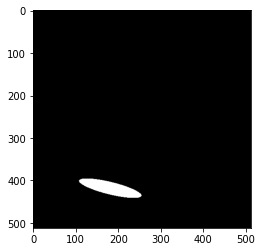

In [14]:
import matplotlib.pyplot as plt
plt.imshow(y_true[20][:,:,0], cmap='gray')
plt.show()

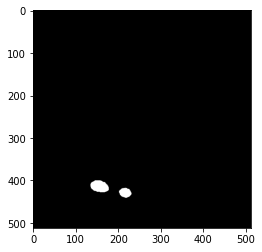

In [15]:
plt.imshow(y_pred[20][:,:,0], cmap='gray')
plt.show()

In [16]:
K.get_value(dice_coef(y_true[20], y_pred[20]))

0.5768451